# Shefa Issachar Simulation

Fun fact: did you know that 'Cash Register' was shot in Petah Tikva?

In [1]:
import numpy as np
import heapq
from pylab import plot, show, bar
import matplotlib.pyplot as plt
import random
import statistics

Class of events: 
There will be 5 events: (1) arriving (2) leaving (3) arguing (4) making a round (5) taking a numa (break)

In [2]:
#Event class
class Event():
    def __init__(self, time, eventType, customer=None):
        self.time = time  # event time
        self.eventType = eventType  # Type of the event
        self.customer = customer
        heapq.heappush(P, self)  # add the event to the events list

    def __lt__(self, event2):
        return self.time < event2.time

Class of customers : there are attributes that we need to know for each customers for running the code. As we know, Natan Franco is nothing like Shuni who is nothing like Amnon who is absolutely nothing like Mrs. Pepperny.

In [3]:
#Customer class
class Customer():
    def __init__(self, arrival_time, i, type=1):
        self.id = i
        self.arrival_time = arrival_time
        self.type = type  # 1 = regular, 2 = Amnon type
        self.round = 0
    
    def __lt__(self, c2):
        return self.arrival_time < c2.arrival_time

The system is supermarket, there are no special attributes we need to save for it.

In [4]:
# Global variables for generic code
#Initialization
T_max = 14 # 14 work hours each day
NUMOFDAYS = 100 # Number of the needed iterations
P = [] # Minimum tree of the events
cust_count = 0 # Total number of customers of naming them
R_avg = {i : [] for i in range(7,21)} # Dictionary for analysis of rounds
L_avg = {i : [] for i in range(7,21)} # Dictionary for analysis of L tilda

## Simulation

In [5]:
#First loop for running NUMOFDAYS days
for i in range(NUMOFDAYS):
    
    #Initialization each day
    A = 0 # The state of the servers: 0 - Both Anatoly and Nissim are available, 1 - Anatoly or Nissim is busy, 2 - Both of them are busy
    L = 0 # Number of customers in the system
    people_in = [] # List of the people in the queue, len(people_in) is the length of the queue
    T_now = 7 # The time of current event
    T_prev = 0 # The time of previous event
    cust_count += 1 # Number of arrived customers, for indexing them
    
    # Creating first event:
    x = np.random.exponential(1 / 20) + 7  # 20 customers per hour means there is a customer every 3 minutes
    t = np.random.random(1)
    if t <= 0.8:
        customer = Customer(x, cust_count)
    else:
        customer = Customer(x, cust_count, 2)
    Event(x, "arriving", customer)
    
    """Initialization of the counters: first L_avg and R_ang are like a diary - we will count each hour the needed values for
       NUMOFDAYS days, then we will calculate the mean of each hour in those dictionary.""" 
    
    for m in L_avg:
        L_avg[m].append(0)
        R_avg[m].append(0)
    
    #The simulation itself: will work until the max time (T_max) or until we don't have anymore events 
    while T_now < T_max + 7 and P:
        
        # Popping the event from P tree (the earliest event)
        event = heapq.heappop(P)
        # If there is an event with customer - we want to work with it
        c = event.customer
        # קידום שעון הסימולציה
        T_prev = T_now
        T_now = event.time
        
        # Calculating the L tilda for each hour
        L_avg[int(T_now)][len(L_avg[int(T_now)])-1] += L*(T_now - T_prev)
        
        if event.eventType == "arriving":
            # If you want to watch the simulation, delete # in the next comment
            #print("Customer no. %d arrived at %s" %(c.id, str(T_now)))
            
            L += 1 # A customer arrived
            if len(people_in) >= 5:
                # The customer will make a round
                c.round += 1
                # Calculating the number of rounds for each hour
                R_avg[int(T_now + (5/60))][len(R_avg[int(T_now + (5/60))]) - 1] += 1
                #Creating event
                Event(T_now + (5/60), "making a round", c)
            else:
                if A < 2: # if the servers are available 
                    A += 1 # one is now busy
                    # Creating event
                    if c.type == 2: #If the customer is annoying
                        Event(T_now + (2/60), "arguing", c)
                    else:
                        Event(T_now + np.random.exponential(1/20), "leaving", c)
                else: # if both of them are busy
                    # adding to queue
                    heapq.heappush(people_in,(c.arrival_time,c))

            
            #Creating the next arriving event
            if T_now < 20: # Because customers arrive only until 8 pm 
                cust_count += 1 # Adding new customer to the system
                if 7 <= T_now < 16:
                    x = np.random.exponential(1 / 20)
                else:
                    x = np.random.exponential(1/40)
                t = np.random.random(1) # Making him regular or annoying
                if t <= 0.8:
                    customer2 = Customer(T_now, cust_count)
                else:
                    customer2 = Customer(T_now, cust_count, 2)
                Event(T_now + x, "arriving", customer2)

        elif event.eventType == "leaving":
            # If you want to watch the simulation, delete # in the next comment
            #print("Customer no. %d left at %s" % (c.id, str(T_now)))
            
            L -= 1 # One customer left the system
            # If this customer was annoying, there is a chance that the server will want to take a numa
            n = 0
            if c.type == 2:
                n = np.random.random(1)
            if n > 0.85:
                # Creating an event
                Event(T_now + (20 / 60), "taking a numa")
            else: # If the server didn't take a numa
                if not people_in: # If there is no one in the queue, make the server available
                    A -= 1
                else:
                    # Creating an event
                    time,c = heapq.heappop(people_in) # Popping the next customer in the queue
                    if c.type == 2: # if he is annoying
                        Event(T_now + (2 / 60), "arguing", c)
                    else:
                        Event(T_now + np.random.exponential(1 / 20), "leaving", c)

        elif event.eventType == "making a round":
            # If you want to watch the simulation, delete # in the next comment
            #print("Customer no. %d making a round at %s" % (c.id, str(T_now)))
            
            if len(people_in) < 5:
                # Means he doesn't need to do another round or abandonment
                if A < 2: # If the server is available
                    # Creating an event
                    if c.type == 2:
                        Event(T_now + (2 / 60), "arguing", c)
                    else:
                        Event(T_now + np.random.exponential(1 / 20), "leaving", c)
                else:
                    # Adding him to the queue
                    heapq.heappush(people_in, (c.arrival_time, c))
            else: # If he needs to do another round
                if c.round < 2:
                    # Calculating the number of rounds for each hour
                    R_avg[int(T_now + (5/60))][len(R_avg[int(T_now + (5/60))]) - 1] += 1
                    # The customer will make a round
                    c.round += 1
                    # Creating an event
                    Event(T_now + (5/60), "making a round", c)
                else:
                    # He does abandonment = one customer less in the system
                    L -= 1

        elif event.eventType == "arguing":
            # If you want to watch the simulation, delete # in the next comment
            #print("Customer no. %d is arguing at %s" % (c.id, str(T_now)))
            
             # Creating an event
            Event(T_now + np.random.exponential(1/20), "leaving", c)

        elif event.eventType == "taking a numa":
            # If you want to watch the simulation, delete """ in the next comments
            """p = np.random.random(1)
            if p <= 0.5:
                print("Anatoly is taking numa")
            else:
                print("Nissim is taking a numa and dreams about his grandmother")"""
            
            if people_in: # If there is a queue
                # Popping the next customer in line
                time, c = heapq.heappop(people_in)
                # Creating an event
                if c.type == 2: # If he is annoying
                    Event(T_now + (2/60), "arguing", c)
                else:
                    Event(T_now + np.random.exponential(1/20), "leaving", c)
            else: # If there is no one in line, make the one server available
                A -= 1
# End of simulation

### Analisys

Creating mean dictionaries for dairy dictionaries with statistics

In [6]:
for t in range (7,21):
    L_avg[int(t)] = statistics.mean(L_avg[int(t)])
    R_avg[int(t)] = statistics.mean(R_avg[int(t)])
    
print(L_avg)
print(R_avg)

{7: 1.553343862202341, 8: 2.145587379773675, 9: 2.1548390720186275, 10: 2.181602482419405, 11: 2.096663273417379, 12: 2.2458879151783533, 13: 2.185986036181158, 14: 2.1008902569135377, 15: 1.8902294721603397, 16: 5.540150775281283, 17: 8.132446448120007, 18: 7.854647219898648, 19: 8.403429420605342, 20: 1.3819634473703306}
{7: 0.78, 8: 1.78, 9: 1.83, 10: 1.82, 11: 1.44, 12: 1.95, 13: 1.58, 14: 1.54, 15: 0.83, 16: 15.95, 17: 32.48, 18: 30.69, 19: 34.91, 20: 3.96}


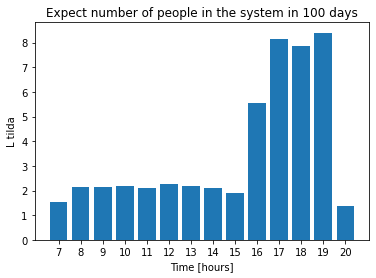

In [7]:
# Plot L_avg
plt.bar(range(len(L_avg)), L_avg.values(), align='center')
plt.xticks(range(len(L_avg)), L_avg.keys())
plt.xlabel('Time [hours]')
plt.ylabel('L tilda')
plt.title('Expect number of people in the system in 100 days')
plt.show()

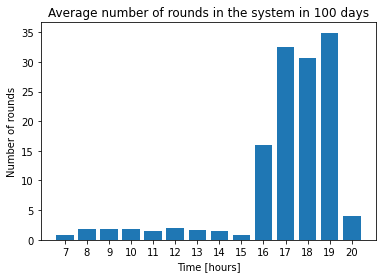

In [8]:
# Plot R_avg
plt.bar(range(len(R_avg)), R_avg.values(), align='center')
plt.xticks(range(len(R_avg)), R_avg.keys())
plt.xlabel('Time [hours]')
plt.ylabel('Number of rounds')
plt.title('Average number of rounds in the system in 100 days')
plt.show()